# Default in credit card

This notebook presents an analysis for the variables in the data set of
credit card clients defaults in Taiwan.

## Attribute Information
This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. This study reviewed the literature and used the following 23 variables as explanatory variables:

* `LIMIT_BAL`: Amount of the given credit (NT dollar): it includes both the individual
consumer credit and his/her family (supplementary) credit.
* `SEX`: Gender (1 = male; 2 = female).
* `EDUCATION`: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
* `MARRIAGE`: Marital status (1 = married; 2 = single; 3 = others).
* `AGE`: Age (year).
* `PAY_0` - `PAY_6`: History of past payment. We tracked the past monthly payment
records (from April to September, 2005) as follows: `PAY_0` = the repayment status in
September, 2005; `PAY_1` = the repayment status in August, 2005; . . .;`PAY_6` = the
repayment status in April, 2005.
    * The measurement scale for the repayment status is:
        * -2: No consumption;
        * -1: Paid in full;
        * 0: The use of revolving credit;
        * 1 = payment delay for one month;
        * 2 = payment delay for two months; . . .;
        * 8 = payment delay for eight months;
        * 9 = payment delay for nine months and above.
* `BILL_AMT1`- `BILL_AMT6`: Amount of bill statement (NT dollar).
`BILL_AMT1` = amount of bill statement in September, 2005;
`BILL_AMT2` = amount of bill statement in August, 2005; . . .;
`BILL_AMT6` = amount of bill statement in April, 2005.
* `PAY_AMT1`- `PAY_AMT6`: Amount of previous payment (NT dollar).
`PAY_AMT1` = amount paid in September, 2005;
`PAY_AMT2` = amount paid in August, 2005; . . .;
`PAY_AMT6` = amount paid in April, 2005.

***
### Import libraries

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import  classification_report
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from mlxtend.plotting import plot_confusion_matrix

# models

from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

# warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

from utils import functions

In [11]:
# notebooks parameters

models_path = '../models'
data_path = '../data'
outputs_path = '../outputs'
filaname_data = 'default of credit card clients.xls'
sheet_name = "Data"

### Load data

In [12]:
df = pd.read_excel(f"{data_path}/{filaname_data}", sheet_name=sheet_name, skiprows=1)

In [13]:
print("The dimension of this Dataset is:", df.shape)
df.head()

The dimension of this Dataset is: (30000, 25)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

In [15]:
# rename target variables
df.rename(columns={'default payment next month':'dpnm'}, inplace=True)
df.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,dpnm
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [16]:
df.isnull().sum()

ID           0
LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
dpnm         0
dtype: int64

* Our target variables is `dpnm`
* Notice that **22.1%** of clients in this dataset will default next month
* Regarding the amount of a given credit, the average is around 167k, with a
standard deviation of 129k (huge large!)
* The average age of clients is around 35 years, with a standard deviation of 9.2.
The younger client is 21 years, and the older is 79.
* There is no null values.
***

### EDA

In [17]:
df['dpnm'].value_counts()

0    23364
1     6636
Name: dpnm, dtype: int64

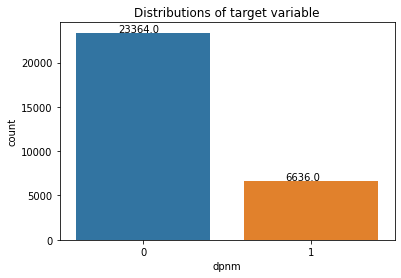

In [18]:
ax = sns.countplot('dpnm', data = df)
plt.title('Distributions of target variable')

for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+50))
plt.savefig(f"{outputs_path}/target_dist.png")
plt.show()

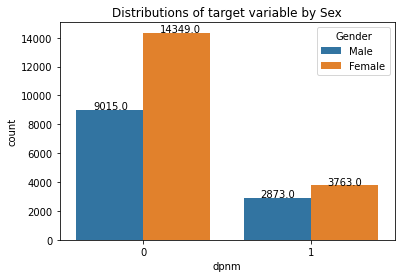

In [19]:
# Gender (1 = male; 2 = female)
ax = sns.countplot('dpnm', hue = 'SEX', data = df)
plt.title('Distributions of target variable by Sex')

for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))
plt.legend(title = 'Gender', labels = ['Male', 'Female'])
plt.savefig(f"{outputs_path}/target_vs_sex.png")
plt.show()

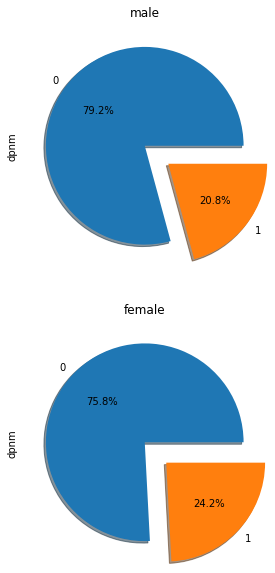

In [20]:
f, ax = plt.subplots(2,figsize=(10,10))
gender=df['SEX'].unique()
list=['male','female']
i=0
for g in gender :
  data = df[df['SEX']==g]
  data = data['dpnm'].value_counts()/data.shape[0]*100
  data.plot.pie(shadow = True, autopct="%.1f%%",explode=(0,0.3), ax=ax[i])
  ax[i].set_title(list[i])
  i+=1
plt.savefig(f"{outputs_path}/sex_dnpm_pie.png")

In [21]:
# some feature correction

df["EDUCATION"] = df["EDUCATION"].apply(lambda x: 4 if ((x!=1) & (x!=2) & (x!=3)) else x )
df["MARRIAGE"] = df["MARRIAGE"].apply(lambda x: 0 if ((x!=1) & (x!=2) & (x!=3)) else x )

***
### Education


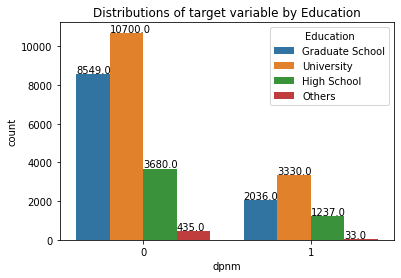

In [22]:
ax = sns.countplot('dpnm', hue = 'EDUCATION', data = df)
plt.title('Distributions of target variable by Education')

for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.0001, p.get_height()+50))
plt.legend(title = 'Education', labels = ['Graduate School','University','High School','Others'])
plt.savefig(f"{outputs_path}/target_vs_edu.png")
plt.show()

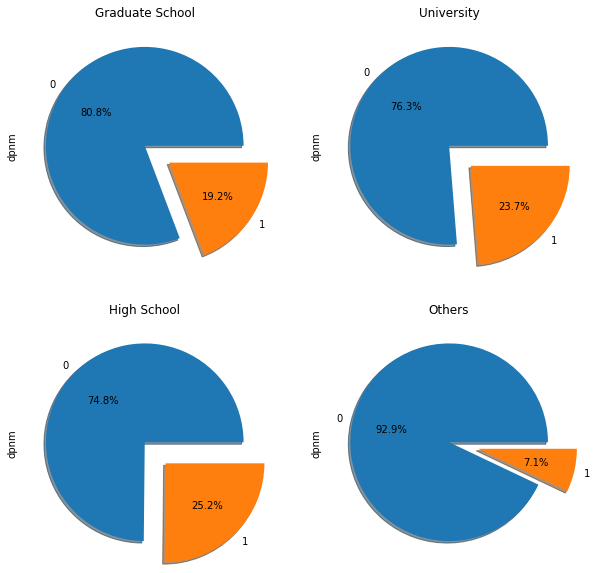

In [23]:
f, ax = plt.subplots(2,2,figsize=(10,10))
edu_level=[1,2,3,4]
list_edu = ['Graduate School','University','High School','Others']
i=0
j=0
for e in edu_level :
  data = df[df['EDUCATION']==e]
  data = data['dpnm'].value_counts()/data.shape[0]*100
  data.plot.pie(shadow = True, autopct="%.1f%%",explode=(0,0.3), ax=ax[i][j])
  ax[i][j].set_title(list_edu[e-1])
  j+=1
  if j%2 == 0:
    i+=1
    j=0
plt.savefig(f"{outputs_path}/edu_dnpm_pie.png")

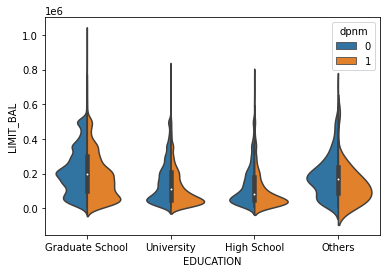

In [24]:
positions = (0,1,2,3)
labels = ("Graduate School", "University" , 'High School','Others')
sns.violinplot(x = 'EDUCATION',
               y ='LIMIT_BAL',
               hue = 'dpnm',
               data = df,
               split = True)
plt.xticks(positions,labels)
plt.savefig(f"{outputs_path}/edu_dnpm_violin.png")

* Within the `Others` category,
the percentage defaulting is **7.1%** and they have to borrow large amounts of money.
* Those in the `High School` group are the least reliable because they have
the highest default rate of **25.2%**.
However, the amounts borrowed by this group are not very large.
* The most risky profile are those with `University` degrees and in `Graduate
schools` because their default rate is **23.7%** and **19.2%** respectively,
and they tend to borrow large amounts of money.

***

### Marital Status

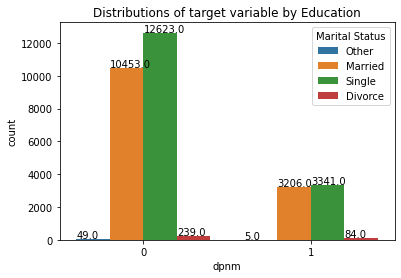

In [25]:
ax = sns.countplot('dpnm', hue = 'MARRIAGE', data = df)
plt.title('Distributions of target variable by Education')

for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.0001, p.get_height()+50))
plt.legend(title = 'Marital Status',
           labels = ['Other','Married','Single','Divorce'])
plt.savefig(f"{outputs_path}/target_vs_marital.png")
plt.show()


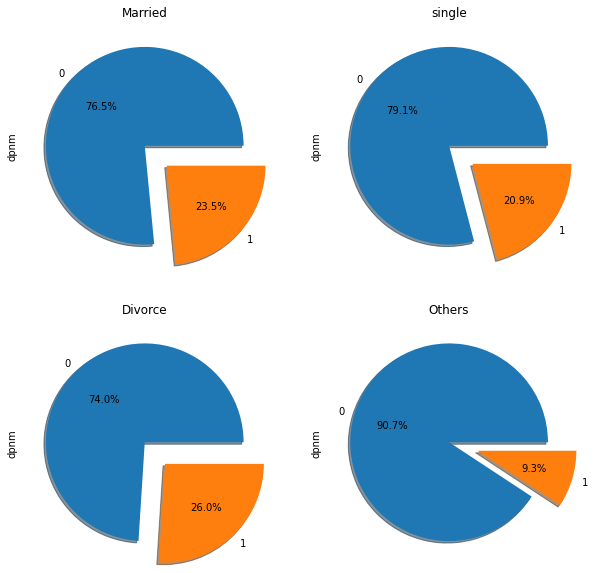

In [26]:
f, ax = plt.subplots(2,2,figsize=(10,10))
m_status = df['MARRIAGE'].unique()
marital_list = ['Married','single','Divorce', 'Others']
i=0
j=0
for m in m_status :
  data = df[df['MARRIAGE']==m]
  data = data['dpnm'].value_counts()/data.shape[0]*100
  data.plot.pie(shadow = True, autopct="%.1f%%",explode=(0,0.3), ax=ax[i][j])
  ax[i][j].set_title(marital_list[m-1])
  j+=1
  if j%2 == 0:
    i+=1
    j=0
plt.savefig(f"{outputs_path}/marital_dnpm_pie.png")

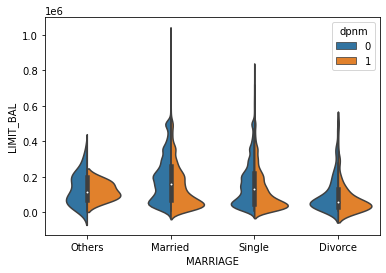

In [27]:
positions = (0,1,2,3)
labels = ("Others", "Married" , 'Single','Divorce')
sns.violinplot(x = 'MARRIAGE',
               y ='LIMIT_BAL',
               hue = 'dpnm',
               data = df,
               split = True)
plt.xticks(positions,labels)
plt.savefig(f"{outputs_path}/marital_dnpm_violin.png")


* `Married` and `Single` people are the biggest problem.
* They have default rates of **23.5%** and **20.9%** respectively

***
### Age

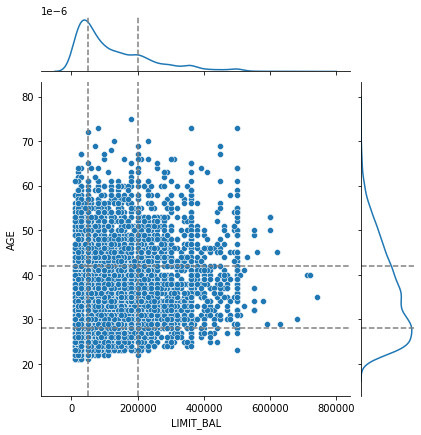

In [28]:
x_max = np.quantile(df['LIMIT_BAL'][df['dpnm']==1], 0.75)
x_min = np.quantile(df['LIMIT_BAL'][df['dpnm']==1], 0.25)
y_max = np.quantile(df['AGE'][df['dpnm']==1], 0.75)
y_min = np.quantile(df['AGE'][df['dpnm']==1], 0.25)

g = sns.JointGrid(data = df[df['dpnm']==1],
                  x="LIMIT_BAL",
                  y="AGE")
g.plot(sns.scatterplot, sns.kdeplot)
g.refline(x = x_max, y = y_max)
g.refline(x = x_min, y = y_min)
plt.savefig(f"{outputs_path}/age_dnpm1_limit_scatter.png")

In [29]:
print(f"From age {y_min} to {y_max} is the most problematic group")


From age 28.0 to 42.0 is the most problematic group


In [30]:
print(x_max)
print(x_min)

200000.0
50000.0


***
### History of past payments



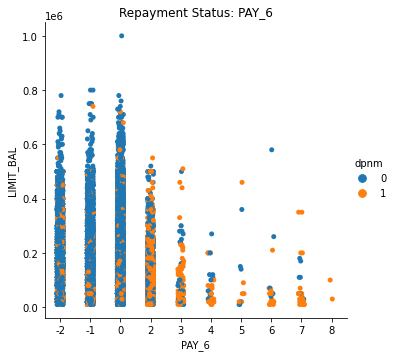

<Figure size 432x288 with 0 Axes>

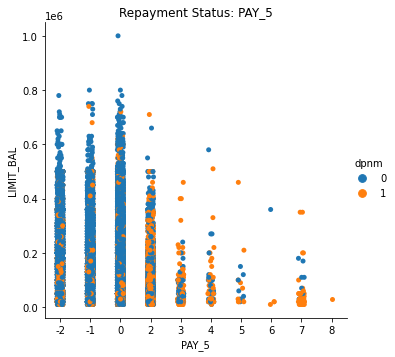

<Figure size 432x288 with 0 Axes>

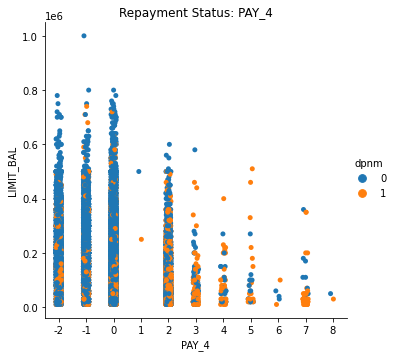

<Figure size 432x288 with 0 Axes>

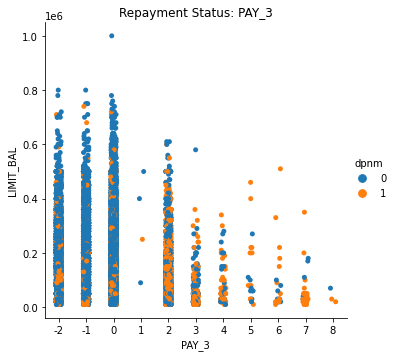

<Figure size 432x288 with 0 Axes>

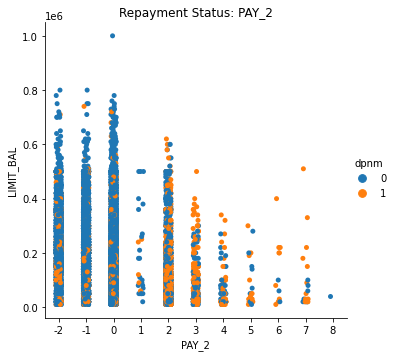

<Figure size 432x288 with 0 Axes>

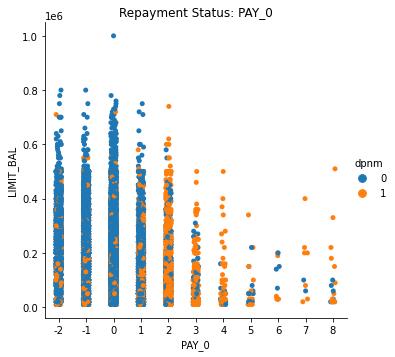

<Figure size 432x288 with 0 Axes>

In [31]:
for pay in ['PAY_6', 'PAY_5', 'PAY_4', 'PAY_3', 'PAY_2', 'PAY_0']:
  sns.catplot(x = pay,
              y ='LIMIT_BAL',
              hue ='dpnm',
              data = df)
  plt.title(f'Repayment Status: {pay}')
  plt.show()
  plt.savefig(f"{outputs_path}/repayment_status_{pay}.png")

* It is observed that when there is a one-month delay in payment,
the probability of not paying at all increases.
***
### Risk Groups based on demographics

In [32]:
df_copy = df.copy()
df_copy['MARRIAGE'] = df_copy['MARRIAGE'].replace(
                            [0,1,2,3],
                            ['others','married','single','divorce'])
df_copy['EDUCATION'] = df_copy['EDUCATION'].replace(
                            [1,2,3,4],
                            ['graduate school', 'university' , 'high school','others'])
df_copy['SEX'] = df_copy['SEX'].replace(
                    [1,2],
                    ["Male", "Female"])

In [33]:
risky_group = df_copy.groupby(['SEX','MARRIAGE','EDUCATION','dpnm'])['LIMIT_BAL'].sum().sort_values(ascending=False).unstack()
risky_group = risky_group.replace(np.NaN,0)
risky_group['risk_capital']=risky_group[1]/risky_group[0]
risky_group

dpnm                                       0            1  risk_capital
SEX    MARRIAGE EDUCATION                                              
Female divorce  graduate school    3350000.0     330000.0      0.098507
                high school        4570000.0     660000.0      0.144420
                others             1060000.0          0.0      0.000000
                university         7800000.0    1740000.0      0.223077
       married  graduate school  418610000.0   79880000.0      0.190822
                high school      188930000.0   45650000.0      0.241624
                others            28660000.0    1140000.0      0.039777
                university       604236000.0  129980000.0      0.215115
       others   graduate school     480000.0          0.0      0.000000
                high school        3850000.0     200000.0      0.051948
                university          670000.0     160000.0      0.238806
       single   graduate school  679980000.0  116890000.0      0.171902
                high school      111950000.0   25760000.0      0.230103
                others            23590000.0    1370000.0      0.058075
                university       501160000.0   97950000.0      0.195447
Male   divorce  graduate school    3060000.0    1900000.0      0.620915
                high school        1960000.0     530000.0      0.270408
                others              250000.0          0.0      0.000000
                university         3480000.0     990000.0      0.284483
       married  graduate school  354530000.0   89070000.0      0.251234
                high school      115500000.0   31370000.0      0.271602
                others            15536000.0    1410000.0      0.090757
                university       303560000.0   80620000.0      0.265582
       others   graduate school     300000.0          0.0      0.000000
                high school         910000.0     250000.0      0.274725
                university          360000.0          0.0      0.000000
       single   graduate school  430940000.0   74820000.0      0.173620
                high school       73320000.0   16837680.0      0.229646
                others            11430000.0     410000.0      0.035871
                university       267090000.0   63490000.0      0.237710

In [34]:
risky_group['ranking_default'] = (risky_group['risk_capital'] -
                             risky_group['risk_capital'].min())/(risky_group['risk_capital'].max() -
                                                               risky_group['risk_capital'].min())
risky_group['raking_limit_defaulted'] = (risky_group[1] -
                  risky_group[1].min())/(risky_group[1].max() -
                                         risky_group[1].min())
risky_group

dpnm                                       0            1  risk_capital  \
SEX    MARRIAGE EDUCATION                                                 
Female divorce  graduate school    3350000.0     330000.0      0.098507   
                high school        4570000.0     660000.0      0.144420   
                others             1060000.0          0.0      0.000000   
                university         7800000.0    1740000.0      0.223077   
       married  graduate school  418610000.0   79880000.0      0.190822   
                high school      188930000.0   45650000.0      0.241624   
                others            28660000.0    1140000.0      0.039777   
                university       604236000.0  129980000.0      0.215115   
       others   graduate school     480000.0          0.0      0.000000   
                high school        3850000.0     200000.0      0.051948   
                university          670000.0     160000.0      0.238806   
       single   graduate school  679980000.0  116890000.0      0.171902   
                high school      111950000.0   25760000.0      0.230103   
                others            23590000.0    1370000.0      0.058075   
                university       501160000.0   97950000.0      0.195447   
Male   divorce  graduate school    3060000.0    1900000.0      0.620915   
                high school        1960000.0     530000.0      0.270408   
                others              250000.0          0.0      0.000000   
                university         3480000.0     990000.0      0.284483   
       married  graduate school  354530000.0   89070000.0      0.251234   
                high school      115500000.0   31370000.0      0.271602   
                others            15536000.0    1410000.0      0.090757   
                university       303560000.0   80620000.0      0.265582   
       others   graduate school     300000.0          0.0      0.000000   
                high school         910000.0     250000.0      0.274725   
                university          360000.0          0.0      0.000000   
       single   graduate school  430940000.0   74820000.0      0.173620   
                high school       73320000.0   16837680.0      0.229646   
                others            11430000.0     410000.0      0.035871   
                university       267090000.0   63490000.0      0.237710   

dpnm                             ranking_default  raking_limit_defaulted  
SEX    MARRIAGE EDUCATION                                                 
Female divorce  graduate school         0.158649                0.002539  
                high school             0.232592                0.005078  
                others                  0.000000                0.000000  
                university              0.359271                0.013387  
       married  graduate school         0.307324                0.614556  
                high school             0.389142                0.351208  
                others                  0.064061                0.008771  
                university              0.346448                1.000000  
       others   graduate school         0.000000                0.000000  
                high school             0.083664                0.001539  
                university              0.384603                0.001231  
       single   graduate school         0.276853                0.899292  
                high school             0.370586                0.198184  
                others                  0.093532                0.010540  
                university              0.314772                0.753577  
Male   divorce  graduate school         1.000000                0.014618  
                high school             0.435499                0.004078  
                others                  0.000000                0.000000  
                university              0.458167                0.007617  
       married  graduate

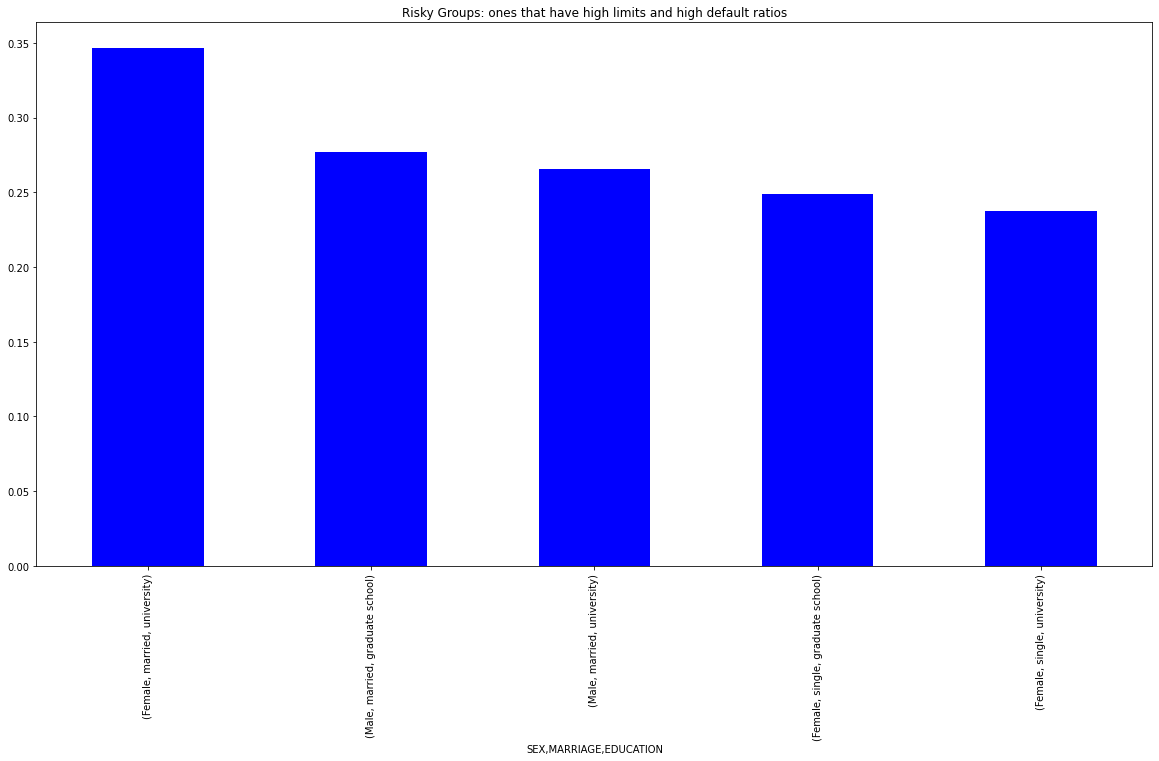

In [35]:
risky_group['risk_score'] = risky_group['ranking_default']*risky_group['raking_limit_defaulted']
risky_group['risk_score'].sort_values(ascending=False)[0:5].plot(kind='bar' , figsize=(20,10),color='blue')
plt.title('Risky Groups: ones that have high limits and high default ratios')
plt.savefig(f"{outputs_path}/risky_groups.png")

In [36]:
print('----------Risky Groups-----------')
risky_group['risk_score'].sort_values(ascending=False)[0:5]

----------Risky Groups-----------


SEX     MARRIAGE  EDUCATION      
Female  married   university         0.346448
Male    married   graduate school    0.277269
                  university         0.265297
Female  single    graduate school    0.248972
                  university         0.237205
Name: risk_score, dtype: float64

***
Conclusion:

* People from age 28 to 42 are the most unreliable age group.
* Females in university or graduate school, either single or married, are very risky.
* If a client delaying their payments for one month, is likelihood of not paying back increment.

***



In [38]:
df.to_csv(f"{data_path}/raw_data.csv", index = False)